In [18]:
import sys
sys.path.append('../..')
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import matplotlib.pyplot as plt
import ta
import numpy as np
import datetime
from IPython.display import clear_output
from utilities.data_manager import ExchangeDataManager
from utilities.custom_indicators import get_n_columns, SuperTrend
from utilities.backtesting import basic_single_asset_backtest, plot_wallet_vs_asset, get_metrics, get_n_columns, plot_sharpe_evolution, plot_bar_by_month
from utilities.custom_indicators import get_n_columns
from utilities.futur_simulations import plot_futur_simulations, plot_train_test_simulation

In [19]:
class SaEnvelope():
    def __init__(
        self,
        df,
        type=["long"],
        ma_base_window=3,
        envelopes=[0.05, 0.1, 0.15],
        src="close",
    ):
        self.df = df
        self.use_long = True if "long" in type else False
        self.use_short = True if "short" in type else False
        self.ma_base_window = ma_base_window
        self.envelopes = envelopes
        self.src = src

        
    def populate_indicators(self):
        # -- Clear dataset --
        df = self.df
        df.drop(
            columns=df.columns.difference(['open','high','low','close','volume']), 
            inplace=True
        )
        
        # -- Populate indicators --    
        if self.src == "close":
            src = df["close"]
        elif self.src == "ohlc4":
            src = (df["close"] + df["high"] + df["low"] + df["open"]) / 4
        # src = df["close"]
        df['ma_base'] = ta.trend.sma_indicator(close=src, window=self.ma_base_window).shift(1)
        high_envelopes = [round(1/(1-e)-1, 3) for e in self.envelopes]
        # low_envelopes = [round(abs(1/(1+e)-1), 3) for e in self.envelopes]
        for i in range(1, len(self.envelopes) + 1):
            df[f'ma_high_{i}'] = df['ma_base'] * (1 + high_envelopes[i-1])
            df[f'ma_low_{i}'] = df['ma_base'] * (1 - self.envelopes[i-1])
        
        self.df = df    
        return self.df
    
    def populate_buy_sell(self): 
        df = self.df
        # -- Initiate populate --
        df["close_long"] = False
        df["close_short"] = False

        for i in range(1, len(self.envelopes) + 1):
            df[f"open_short_{i}"] = False
            df[f"open_long_{i}"] = False
        
        if self.use_long:
            # -- Populate open long--
            for i in range(1, len(self.envelopes) + 1):
                df.loc[
                    (df['low'] <= df[f'ma_low_{i}'])
                    , f"open_long_{i}"
                ] = True
            
            # -- Populate close long limit --
            df.loc[
                (df['high'] >= df['ma_base'])
                , "close_long"
            ] = True
            
        
        if self.use_short:
            # -- Populate open short limit --
            for i in range(1, len(self.envelopes) + 1):
                df.loc[
                    (df['high'] >= df[f'ma_high_{i}'])
                    , f"open_short_{i}"
                ] = True
            
            # -- Populate close short market --
            df.loc[
                (df['low'] <= df['ma_base'])
                , "close_short"
            ] = True
        
        self.df = df   
        return self.df
        
    def run_backtest(self, initial_wallet=1000, leverage=1):
        df = self.df[:]
        wallet = initial_wallet
        maker_fee = 0.0002
        taker_fee = 0.0007
        trades = []
        days = []
        current_day = 0
        previous_day = 0
        current_position = None

        for index, row in df.iterrows():
            
            # -- Add daily report --
            current_day = index.day
            if previous_day != current_day:
                temp_wallet = wallet
                if current_position:
                    if current_position['side'] == "LONG":
                        close_price = row['close']
                        trade_result = (close_price - current_position['price']) / current_position['price']
                        temp_wallet += current_position['size'] * trade_result
                        fee = temp_wallet * taker_fee
                        temp_wallet -= fee
                    elif current_position['side'] == "SHORT":
                        close_price = row['close']
                        trade_result = (current_position['price'] - close_price) / current_position['price']
                        temp_wallet += current_position['size'] * trade_result
                        fee = temp_wallet * taker_fee
                        temp_wallet -= fee
                    
                days.append({
                    "day":str(index.year)+"-"+str(index.month)+"-"+str(index.day),
                    "wallet":temp_wallet,
                    "price":row['close']
                })
            previous_day = current_day
            if current_position:
            # -- Check for closing position --
                if current_position['side'] == "LONG":                     
                    # -- Close LONG market --
                    if row['close_long'] and (current_position["envelope"] == len(self.envelopes) or row[f'open_long_{current_position["envelope"] + 1}'] is False):
                        close_price = row['ma_base']
                        trade_result = (close_price - current_position['price']) / current_position['price']
                        wallet += current_position['size'] * trade_result
                        close_trade_size = current_position['size'] + (current_position['size'] * trade_result)
                        fee = close_trade_size * maker_fee
                        wallet -= fee
                        trades.append({
                            "open_date": current_position['date'],
                            "close_date": index,
                            "position": "LONG",
                            "open_reason": current_position['reason'],
                            "close_reason": "Limit",
                            "open_price": current_position['price'],
                            "close_price": close_price,
                            "open_fee": current_position['fee'],
                            "close_fee": fee,
                            "open_trade_size":current_position['size'],
                            "close_trade_size": close_trade_size,
                            "wallet": wallet
                        })
                        current_position = None
                        
                elif current_position['side'] == "SHORT":
                    # -- Close SHORT Limit --
                    if row['close_short'] and (current_position["envelope"] == len(self.envelopes) or row[f'open_short_{current_position["envelope"] + 1}'] is False):
                        # if current_position['reason'] == "Limit Envelop 3":
                        #     print("ok")
                        close_price = row['ma_base']
                        trade_result = (current_position['price'] - close_price) / current_position['price']
                        wallet += current_position['size'] * trade_result
                        close_trade_size = current_position['size'] + (current_position['size'] * trade_result)
                        fee = close_trade_size * maker_fee
                        wallet -= fee
                        trades.append({
                            "open_date": current_position['date'],
                            "close_date": index,
                            "position": "SHORT",
                            "open_reason": current_position['reason'],
                            "close_reason": "Limit",
                            "open_price": current_position['price'],
                            "close_price": close_price,
                            "open_fee": current_position['fee'],
                            "close_fee": fee,
                            "open_trade_size": current_position['size'],
                            "close_trade_size": close_trade_size,
                            "wallet": wallet
                        })
                        current_position = None

            # -- Check for opening position --
            for i in range(1, len(self.envelopes) + 1):
                # -- Open long Limit --
                if row[f'open_long_{i}']:
                    if current_position and (current_position["envelope"] >= i or current_position["side"] == "SHORT"):
                        continue
                    open_price = row[f'ma_low_{i}']
                    fee = wallet * maker_fee * (1/len(self.envelopes)) * leverage
                    wallet -= fee
                    pos_size = wallet * (1/len(self.envelopes)) * leverage
                    if current_position:
                        current_position["price"] = (current_position["size"] * current_position["price"] + open_price * pos_size) / (current_position["size"] + pos_size)
                        current_position["size"] = current_position["size"] + pos_size
                        current_position["fee"] = current_position["fee"] + fee
                        current_position["envelope"] = i
                        current_position["reason"] = f"Limit Envelop {i}"
                    else:
                        current_position = {
                            "size": pos_size,
                            "date": index,
                            "price": open_price,
                            "fee":fee,
                            "reason": f"Limit Envelop {i}",
                            "side": "LONG",
                            "envelope": i,
                        }
                elif row[f'open_short_{i}']:
                    if current_position and (current_position["envelope"] >= i or current_position["side"] == "LONG"):
                        continue
                    open_price = row[f'ma_high_{i}']
                    fee = wallet * maker_fee * (1/len(self.envelopes)) * leverage
                    wallet -= fee
                    pos_size = wallet * (1/len(self.envelopes)) * leverage
                    if current_position:
                        current_position["price"] = (current_position["size"] * current_position["price"] + open_price * pos_size) / (current_position["size"] + pos_size)
                        current_position["size"] = current_position["size"] + pos_size
                        current_position["fee"] = current_position["fee"] + fee
                        current_position["envelope"] = i
                        current_position["reason"] = f"Limit Envelop {i}"
                    else:
                        current_position = {
                            "size": pos_size,
                            "date": index,
                            "price": open_price,
                            "fee":fee,
                            "reason": f"Limit Envelop {i}",
                            "side": "SHORT",
                            "envelope": i,
                        }
                else:
                    break
                    
                    
        df_days = pd.DataFrame(days)
        df_days['day'] = pd.to_datetime(df_days['day'])
        df_days = df_days.set_index(df_days['day'])

        df_trades = pd.DataFrame(trades)
        if df_trades.empty:
            print("!!! No trades")
            return None
        else:
            df_trades['open_date'] = pd.to_datetime(df_trades['open_date'])
            df_trades = df_trades.set_index(df_trades['open_date'])  
        
        return get_metrics(df_trades, df_days) | {
            "wallet": wallet,
            "trades": df_trades,
            "days": df_days
        } 

In [20]:
exchange_name = "binance"
pair = "ETH/USDT"
tf = "1h"

exchange = ExchangeDataManager(
    exchange_name=exchange_name, 
    path_download="../database/exchanges"
)

df = exchange.load_data(
    coin=pair, 
    interval=tf
)

╒═════════════════════════════╤══════════════════════════════════════╕
│ Résultats backtest          │ ETH/USDT(1h)                         │
╞═════════════════════════════╪══════════════════════════════════════╡
│ Période                     │ 17.08.2017 -> 27.12.2023             │
│ Portefeuille initial        │ 1,000.00 $                           │
│                             │                                      │
│ Portefeuille final          │ 1,797,933.70 $                       │
│ Performance vs US dollar    │ 179,693.37 %                         │
│ Pire Drawdown T|D           │ -35.21% | -44.04%                    │
│ Buy and hold performance    │ 638.02 %                             │
│ Performance vs buy and hold │ 24,261.61 %                          │
│ Nombre total de trades      │ 215                                  │
│ Sharpe Ratio                │ 2.47                                 │
│ Global Win rate             │ 86.05 %                              │
│ Prof

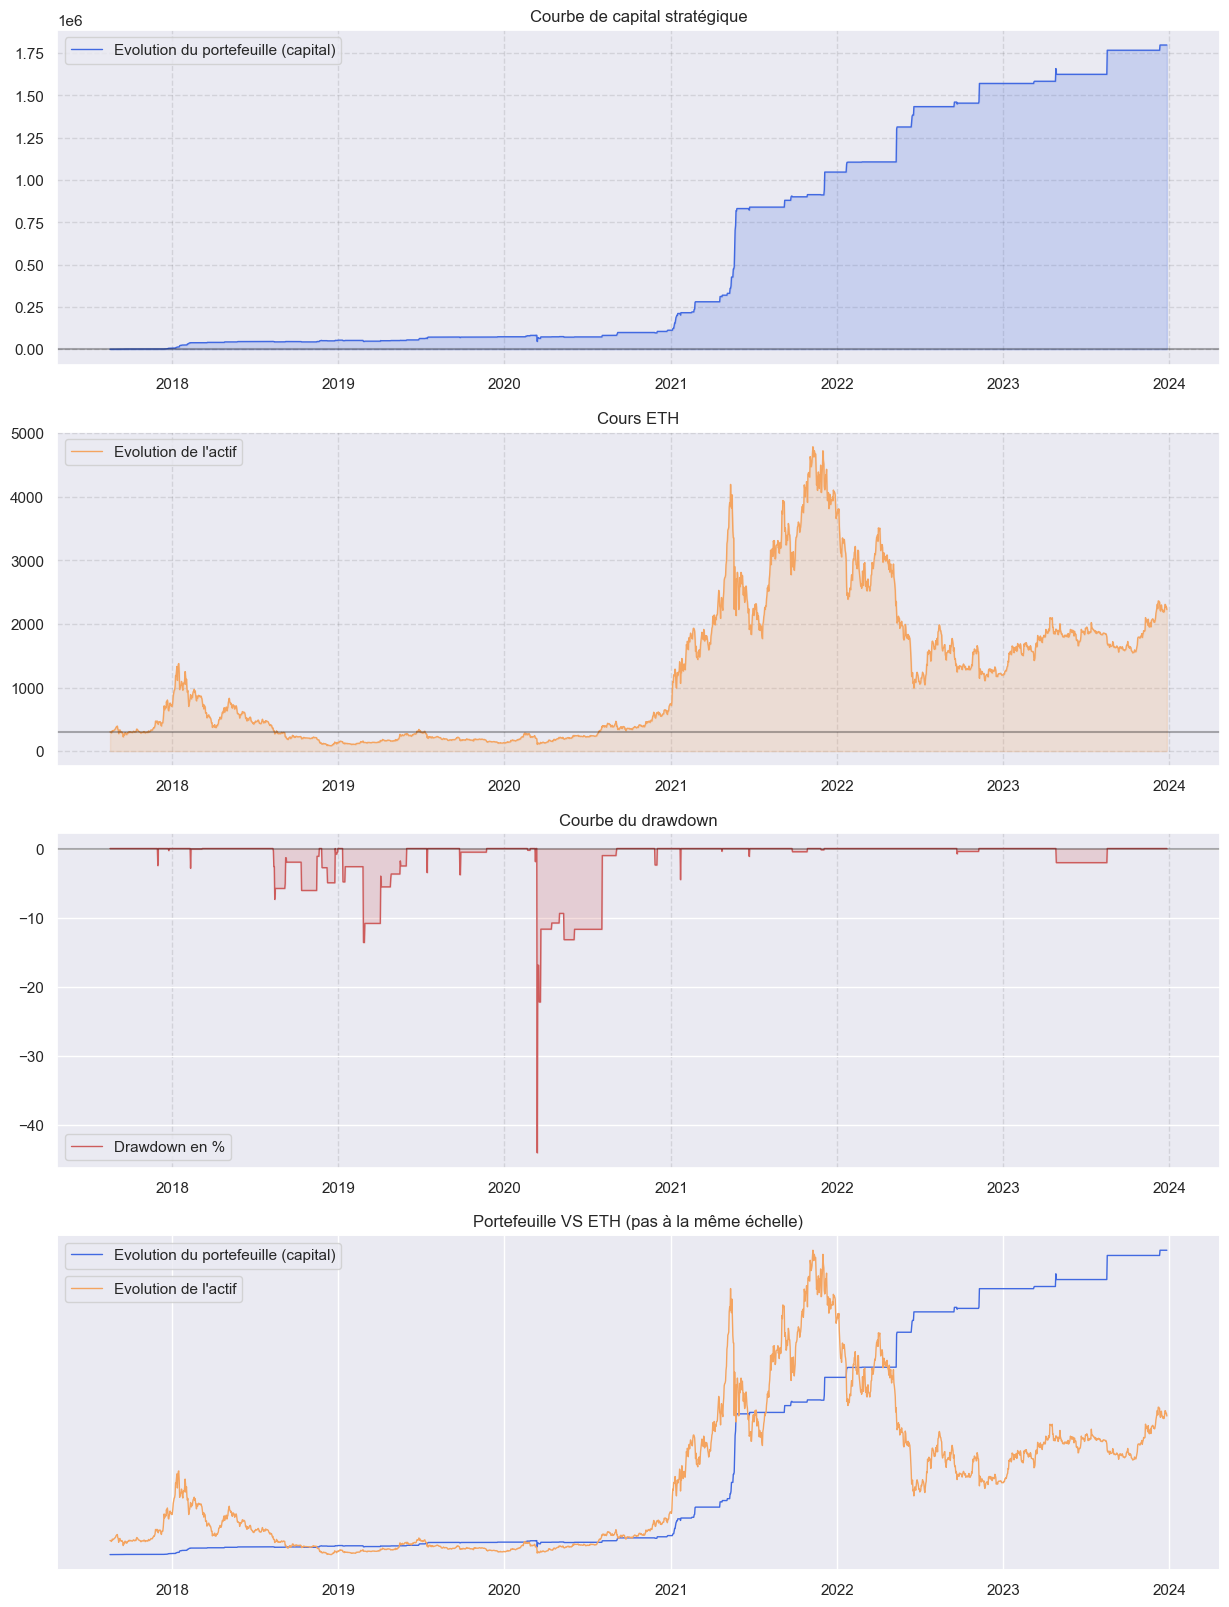

In [27]:
# strat = SaEnvelope( # BTC
#     df = df.loc["2020":],
#     type=["long", "short"],
#     ma_base_window=7,
#     envelopes=[0.07, 0.1],
#     src="close",
# )
strat = SaEnvelope( # ETH
    df = df.loc[:],
    type=["long", "sh1ort"],
    ma_base_window=5,
    envelopes=[0.07, 0.09, 0.12],
    src="close",
)
# strat = SaEnvelope( # ADA EGLD
#     df = df.loc["2020":],
#     type=["long", "short"],
#     ma_base_window=5,
#     envelopes=[0.07, 0.09, 0.12, 0.15],
#     src="close",
# )
# strat = SaEnvelope( # KSM OCEAN REN BAR
#     df = df.loc["2020":],
#     type=["long", "short"],
#     ma_base_window=5,
#     envelopes=[0.07, 0.1, 0.15, 0.2],
#     src="close",
# )

strat.populate_indicators()
strat.populate_buy_sell()
bt_result = strat.run_backtest(initial_wallet=1000, leverage=2)

df_trades, df_days = basic_single_asset_backtest(trades=bt_result['trades'], days=bt_result['days'], pair=pair, tf=tf)

plot_wallet_vs_asset(df_days=df_days, pair=pair)

----- 2017 Performances cumulées: 4894.22% --


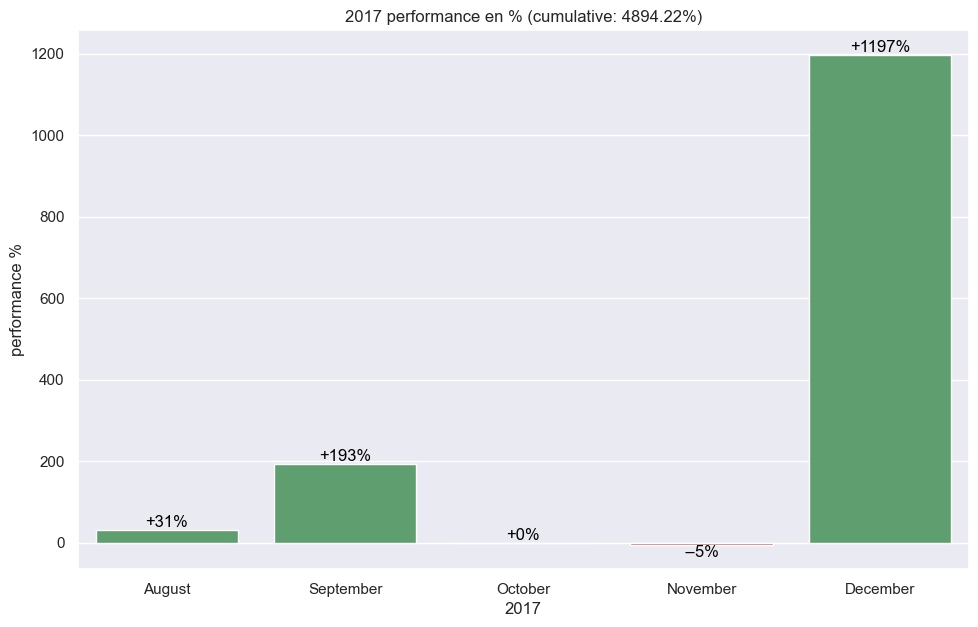

----- 2018 Performances cumulées: 4220.26% --


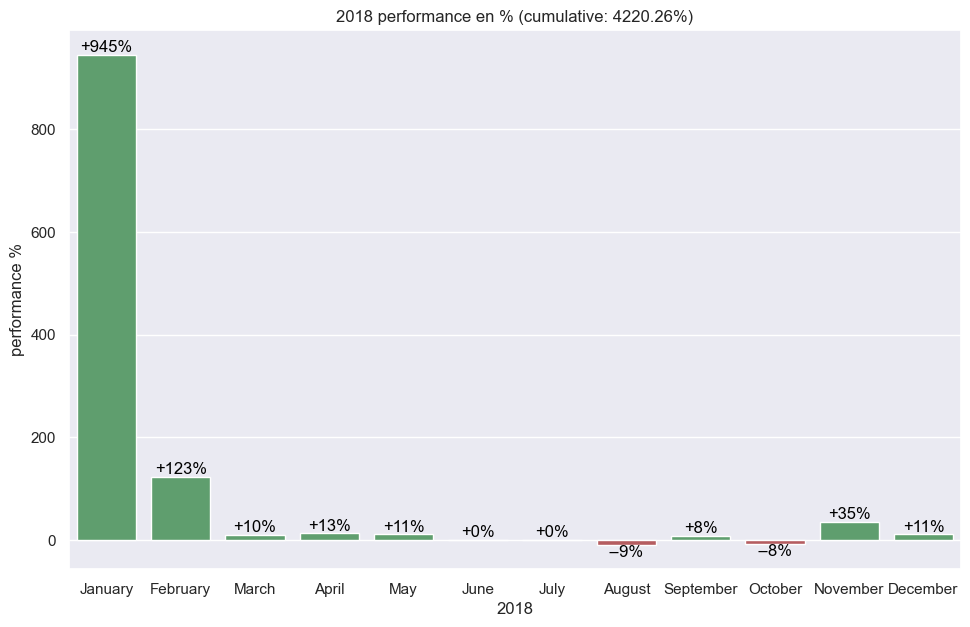

----- 2019 Performances cumulées: 79.33% --


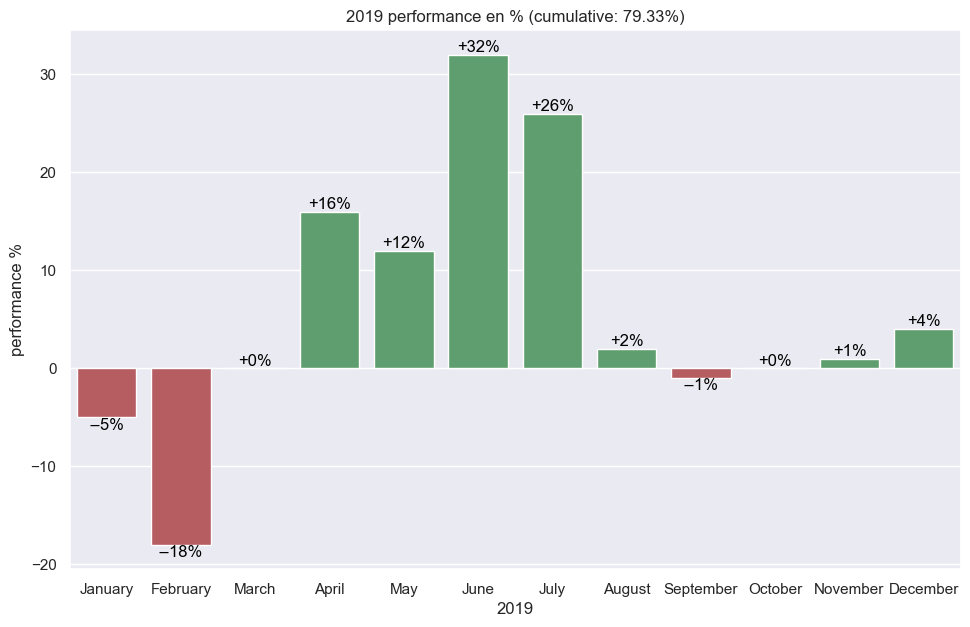

----- 2020 Performances cumulées: 88.54% --


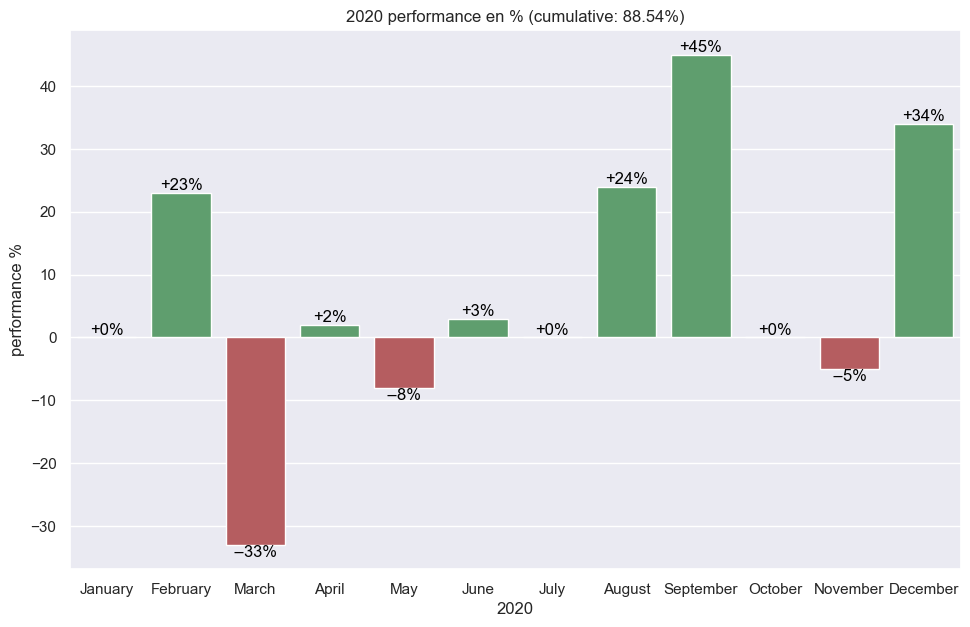

----- 2021 Performances cumulées: 6927.11% --


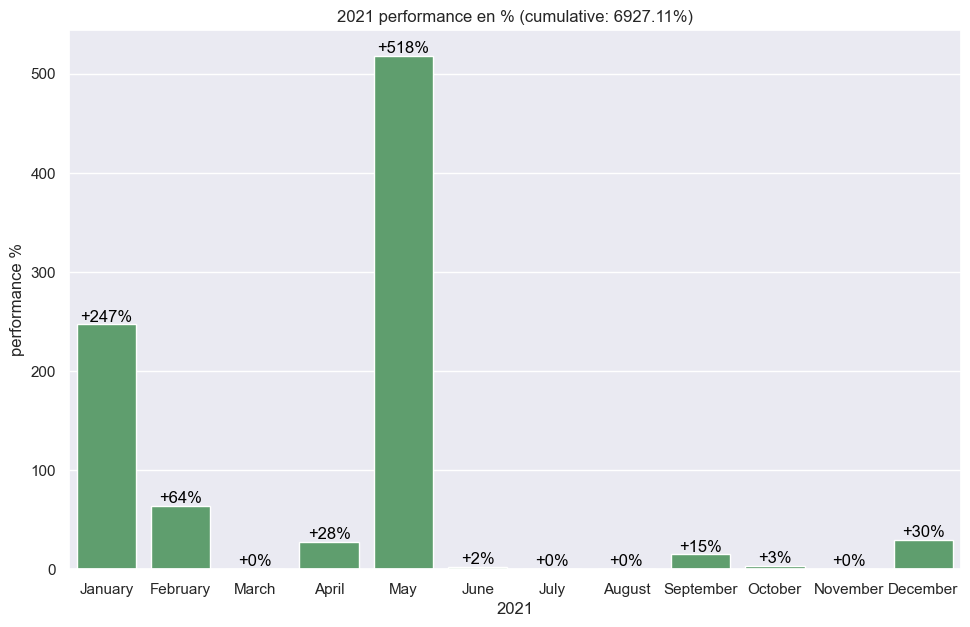

----- 2022 Performances cumulées: 120.37% --


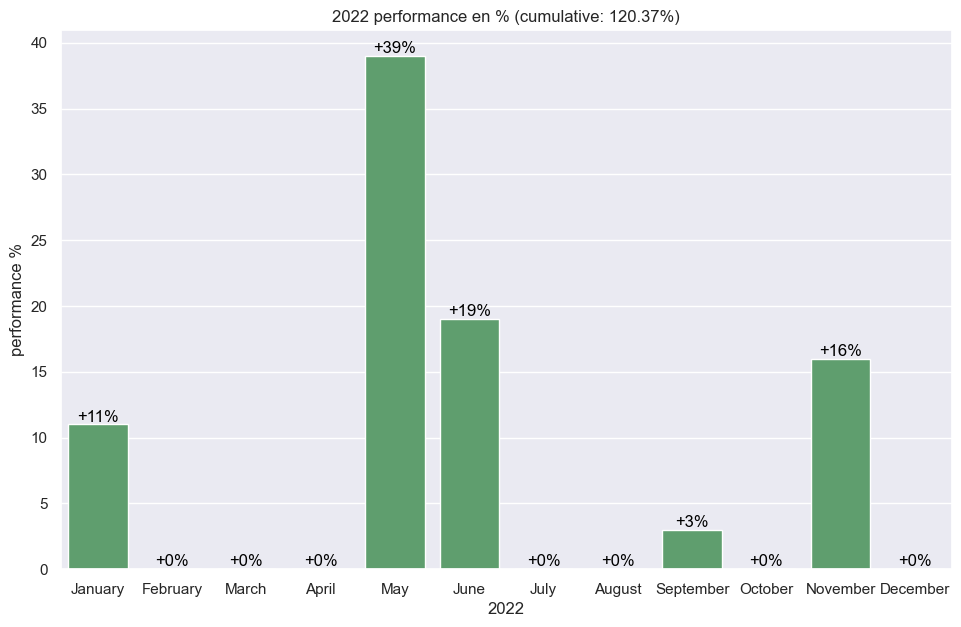

----- 2023 Performances cumulées: 29.99% --


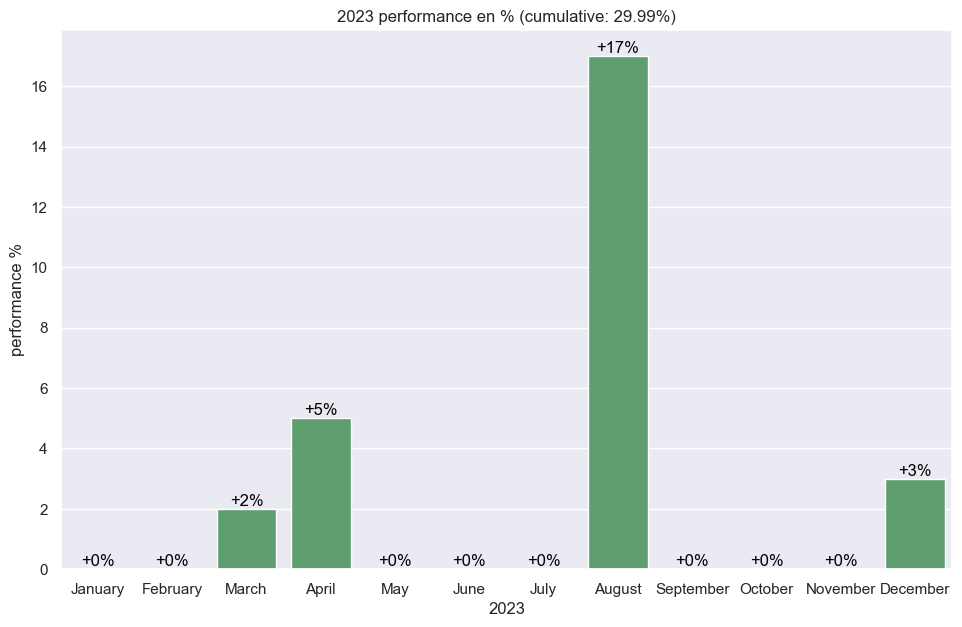

In [22]:
plot_bar_by_month(df_days)

<H2>Courbe de surapprentissage</H2>

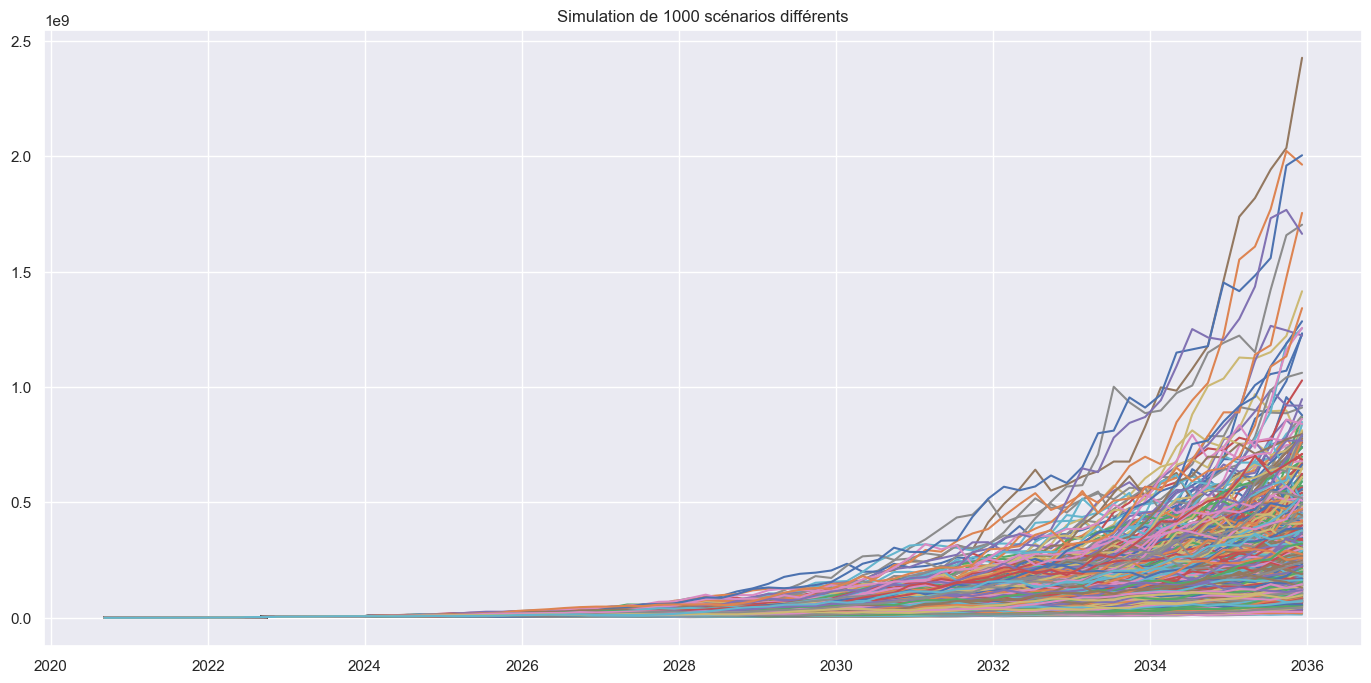

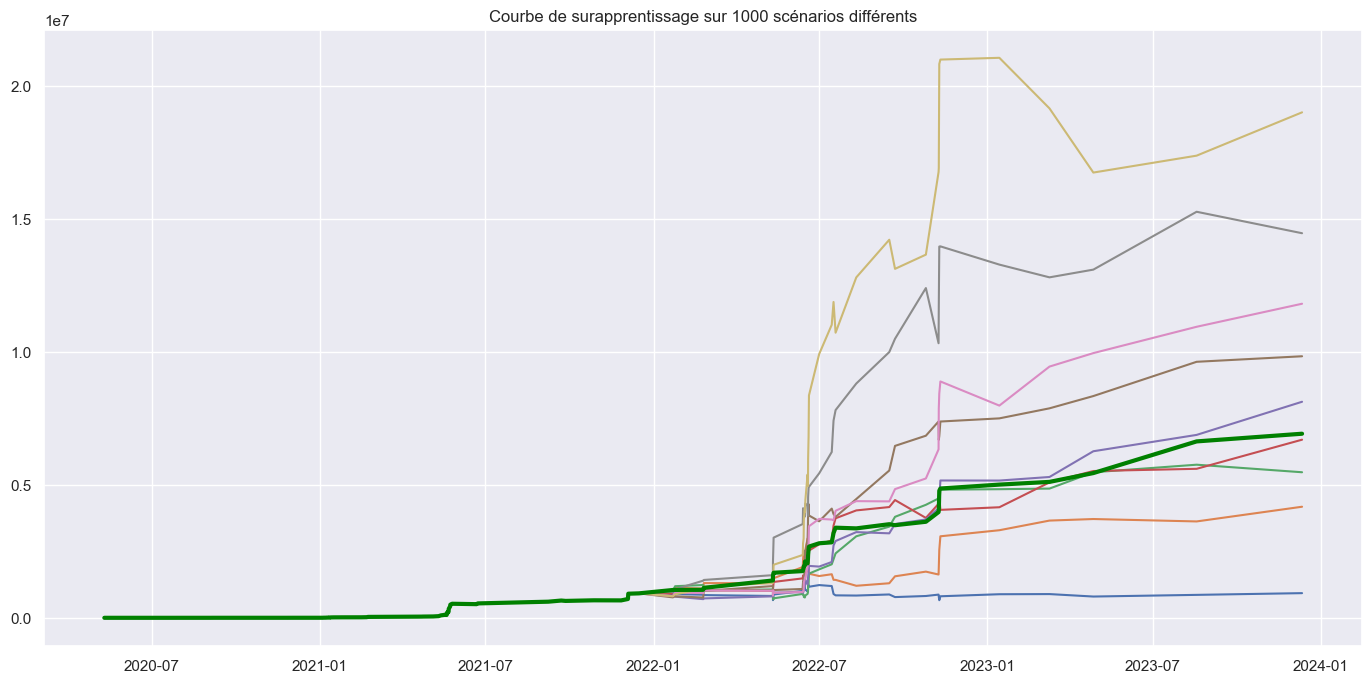

In [14]:
# Simulation de divers scénarios futurs
plot_futur_simulations(
    df_trades=df_trades,
    trades_multiplier=3,
    trades_to_forecast=60,
    number_of_simulations=1000,
    true_trades_to_show=100,
    show_all_simulations=True
)

# Comparaison entre les divers scénarios et la réalité pour voir si il y a du surapprentissage
# Séparation des échantillons en train et en test - Méthode de Monte Carlo (Loi normale)
plot_train_test_simulation(
    df_trades=df_trades,
    train_test_date="2022-01-01",
    trades_multiplier=3,
    number_of_simulations=1000,
)